In [1]:
import pickle
import os
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
    np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [ ]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [4]:
experimental_data_STANDARD = LiH_data['experiment_data'].copy()
del LiH_data

In [5]:
STANDARD_data = experimental_data_STANDARD[101852100]['standard'].copy()
del experimental_data_STANDARD

In [6]:
len(STANDARD_data)

10

In [7]:
STANDARD_Hist_data_sim={} 
for exp_instance in STANDARD_data: #each exp repeated 10 times!
    for exp_dict_key in exp_instance:
        
        exp_dict= exp_instance[exp_dict_key]
        
        P=exp_dict['qubitOp']
        coeff = exp_dict['coeff']
        measured_dict_sim = exp_dict['measurement_dict']

        M_list_sim = dict_of_M_to_list(measured_dict_sim, P)

        if exp_dict_key in STANDARD_Hist_data_sim.keys():
            STANDARD_Hist_data_sim[exp_dict_key]={'P':list(P.terms.items())[0] ,'coeff': coeff.real, 'Measurements': np.hstack((STANDARD_Hist_data_sim[exp_dict_key]['Measurements'],M_list_sim))}
        else:
            STANDARD_Hist_data_sim[exp_dict_key]={'P':list(P.terms.items())[0] ,'coeff': coeff.real, 'Measurements': M_list_sim}
            
        del exp_dict

In [8]:
del STANDARD_data

In [9]:
# for key in STANDARD_Hist_data_sim:
#     STANDARD_Hist_data_sim[key]['Measurements']=STANDARD_Hist_data_sim[key]['Measurements'].tolist()
#     STANDARD_Hist_data_sim[key]['P']=(STANDARD_Hist_data_sim[key]['P'][0], STANDARD_Hist_data_sim[key]['P'][1].real)

In [10]:
# import json
# with open("STANDARD_Hist_data_sim", "w") as write_file:
#     json.dump(STANDARD_Hist_data_sim, write_file)


In [11]:
STANDARD_Hist_data_sim[0]['Measurements'].shape

(1616700,)

In [12]:
# ### save output
# np.save('Standard_hist_data', STANDARD_Hist_data_sim)

In [13]:
import matplotlib.pyplot as plt

In [14]:
fci_energy= -7.971184315565538

# Histogram

In [15]:
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[0]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    

In [16]:
I_term = -4.142299396835105
E_list_STANDARD_sim=Get_Hist_data(STANDARD_Hist_data_sim, I_term)

100%|██████████| 1616700/1616700 [49:58<00:00, 539.08it/s] 


In [17]:
import json
with open("E_list_STANDARD_sim.json", "w") as write_file:
    json.dump(E_list_STANDARD_sim, write_file)


In [18]:
E_list_STANDARD_sim=np.array(E_list_STANDARD_sim)

In [19]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

In [20]:
from scipy.optimize import curve_fit

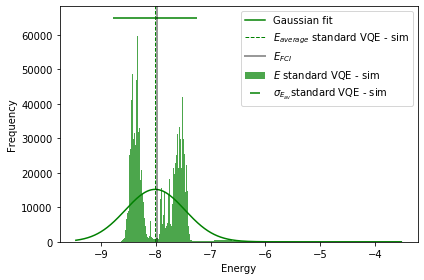

In [21]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
bins_standard = 500

bin_heights_STANDARD, bin_borders_STANDARD, _=pyplot.hist(E_list_STANDARD_sim,
                                                          bins_standard, alpha=0.7,
                                                          label='$E$ standard VQE - sim',
                                                          color='g',
                                                          density=False)

bin_centers_STANDARD = bin_borders_STANDARD[:-1] + np.diff(bin_borders_STANDARD) / 2
popt, _ = curve_fit(gaussian, bin_centers_STANDARD, bin_heights_STANDARD, p0=[fci_energy, 0., 1.], **{'maxfev':10000})
mean_STANDARD, amplitude_STANDARD, standard_deviation_STANDARD= popt
x_interval_for_fit = np.linspace(bin_borders_STANDARD[0], bin_borders_STANDARD[-1], 10000)
pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='g')


pyplot.axvline(mean_STANDARD, color='g', linestyle='dashed', linewidth=1, 
            label='$E_{average}$ standard VQE - sim') # mean of GAUSSIAN FIT

# pyplot.axvline(E_list_STANDARD_sim.mean(), color='g', linestyle='dashed', linewidth=1, 
#             label='$E_{average}$ standard VQE - sim') # mean of DATA

pyplot.errorbar(mean_STANDARD,65_000,
             xerr=standard_deviation_STANDARD, linestyle="None", color='g',
             uplims=True, lolims=True, label='$\sigma_{E_{av}}$standard VQE - sim')




pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=2, 
            label='$E_{FCI}$', alpha=0.4)

pyplot.legend(loc='upper right')
# pyplot.legend(bbox_to_anchor=(0.865,1.9), loc="upper left")
pyplot.ylabel('Frequency')
pyplot.xlabel('Energy')

pyplot.tight_layout()

file_name = 'LiH_Histogram_STANDARD_sim_Gaussian.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()